In [21]:
import pandas as pd
import sklearn.tree as sktree
import scipy as sp
import os
path="C:/Users/SAMSUNG/Desktop/decisiontree"
filename=os.listdir(path)

## 변수설정

### Target(Y)

target = 침수여부

In [22]:
target=pd.read_csv(path+"/침수지역2022.csv")

위의 데이터는 침수지역의 빈도(frequency)이므로 바꿔야함

In [23]:
print('한번이라도 침수가 일어난 지역수(행정동) :',target["ADM_NM"].nunique())

한번이라도 침수가 일어난 지역수(행정동) : 277


In [24]:
target["ADM_NM"]

0         우이동
1         우이동
2         우이동
3        영등포동
4         송중동
        ...  
8882      청파동
8883      한남동
8884    원효로2동
8885      동선동
8886    북가좌2동
Name: ADM_NM, Length: 8887, dtype: object

In [25]:
target["ADM_CD"]

0       1130510400
1       1130510400
2       1130510400
3       1156010400
4       1130510100
           ...    
8882    1117013100
8883    1117010800
8884    1117011300
8885    1129010300
8886    1141011900
Name: ADM_CD, Length: 8887, dtype: int64

In [26]:
target["ADM_CD_2"]

0       1109074
1       1109074
2       1109074
3       1119074
4       1109071
         ...   
8882    1103071
8883    1103074
8884    1103057
8885    1108083
8886    1113072
Name: ADM_CD_2, Length: 8887, dtype: int64

### Feature(X)

In [27]:
filename

['2. 가공데이터',
 '경사도.xlsx',
 '도로현황(도로율)_20231015181102.csv',
 '반출_행정동_소득가구_수정.xlsx',
 '반출_행정동_소득가구_수정2차.xlsx',
 '배수등급양호비율.csv',
 '서울시_강우량_정보_2022년',
 '서울시_행정동별_인구밀도_2023.csv',
 '여성.csv',
 '장애인.csv',
 '재해위험지구_경계도.csv',
 '제방.csv',
 '제방암거수문_있다없다.csv',
 '제방암거수문개수.csv',
 '침수지역2022.csv',
 '침수흔적도2022.csv',
 '토양도',
 '하천까지의_거리.csv',
 '행정동_공시지가_2020.xlsx',
 '행정동_법정동.ipynb']

In [28]:
경사도=pd.read_excel(path+"/경사도.xlsx")
행정공시지가=pd.read_excel(path+"/"+'행정동_공시지가_2020.xlsx')
도로율=pd.read_csv(path+"/"+"도로현황(도로율)_20231015181102.csv")
배수등급양호비율=pd.read_csv(path+"/"+"배수등급양호비율.csv")
하천까지의거리=pd.read_csv(path+"/"+'하천까지의_거리.csv')
제방암거수문=pd.read_csv(path+"/"+'제방암거수문_있다없다.csv')
인구밀도=pd.read_csv(path+"/"+'서울시_행정동별_인구밀도_2023.csv')
행정동소득분위=pd.read_excel(path+"/"+"반출_행정동_소득가구_수정2차.xlsx")

사회인프라

In [29]:
path2=path+"/"+'2. 가공데이터'

In [30]:
장애인=pd.read_csv(path2+"/"+"장애인.csv")
노인=pd.read_csv(path2+"/"+'노인.csv')
기초수급자=pd.read_csv(path2+"/"+"기초수급자.csv")
기초수급자_65세이상=pd.read_csv(path2+"/"+'기초생활수급자+65세이상.csv')

강우량

In [31]:
path3=path+"/"+'서울시_강우량_정보_2022년'

In [32]:
rain_dict={}
for i in range(1,10):
    rain_dict[i]=pd.read_csv(path3+"/"+f'서울시_강우량_정보_2022년0{i}월.csv',encoding='euc-kr')
for j in range(10,13):
    rain_dict[j]=pd.read_csv(path3+"/"+f'서울시_강우량_정보_2022년{j}월.csv',encoding='euc-kr')

In [33]:
rain_data=pd.concat([rain_dict[i][rain_dict[i]["10분우량"]!=0] for i in range(1,13)])
rain_agg=rain_data.groupby(["구청명"])["10분우량"].agg(["sum","count"])
rain_agg.rename(columns=dict(zip(["sum","count"],["누적강수량","10분당 측정(횟수)"])),inplace=True)
rain_agg.index.rename(None,inplace=True)

In [34]:
rain_agg["추정시우량(연간)"]=rain_agg["누적강수량"]/(rain_agg["10분당 측정(횟수)"]/6)

In [35]:
rain_agg.index.rename("시군구",inplace=True)
rain_agg.reset_index(inplace=True)

In [36]:
구면적=pd.DataFrame(인구밀도.groupby(["구"])["면적 (k㎡)"].sum()).reset_index()
구면적.rename(columns={"구":"시군구"},inplace=True)

In [37]:
rain_agg=pd.merge(rain_agg,구면적)
rain_agg["추정면적당시우량(연간)"]=rain_agg["추정시우량(연간)"]/rain_agg["면적 (k㎡)"]

In [38]:
rain_agg

,시군구,누적강수량,10분당 측정(횟수),추정시우량(연간),면적 (k㎡),추정면적당시우량(연간)
0,강남구,6044.5,4063,8.926163,39.51,0.225922
1,강동구,3829.0,2745,8.369399,24.59,0.340358
2,강북구,1803.5,1382,7.829957,23.60,0.331778
3,강서구,3076.5,2574,7.171329,41.44,0.173053
4,관악구,3777.0,2609,8.686087,29.57,0.293747
5,광진구,1887.0,1353,8.368071,17.06,0.490508
6,구로구,3553.5,2333,9.138877,20.12,0.454219
7,금천구,3648.0,2539,8.620717,13.02,0.662113
8,노원구,3686.5,2816,7.854759,35.44,0.221635
9,도봉구,1932.0,1435,8.078049,20.65,0.391189


### 데이터 병합

행정동 단위
> 경사도, 행정공시지가, 배수등급양호비율, 하천까지의 거리, 제방수문암거

In [39]:
# import PublicDataReader as pdr
# 행정동코드 = pdr.code_hdong()
# import numpy as np
# 행정동=행정동코드[행정동코드["시도명"]=="서울특별시"][["시군구명","읍면동명"]]
# 행정동.index=행정동.index.astype('int')
# 행정동["시군구명"]=행정동["시군구명"].str.strip()
# 행정동["읍면동명"]=행정동["읍면동명"].str.strip()
# 행정동=행정동[행정동["시군구명"]!=""][행정동["읍면동명"]!=""]

----------

In [40]:
per_경사도=pd.DataFrame(경사도.groupby(["ADM_NM"])["경사도"].mean())
per_경사도.reset_index(inplace=True)

In [41]:
pre_경사도=pd.merge(경사도[["GU_NAME","ADM_NM"]],per_경사도,how='left')
pre_경사도["경사도(%)"]=pre_경사도["경사도"]*100
pre_경사도.drop_duplicates(["ADM_NM"],inplace=True)

In [42]:
pre_경사도

,GU_NAME,ADM_NM,경사도,경사도(%)
0,종로구,이화동,0.078333,7.833333
1,종로구,숭인2동,0.053125,5.312500
2,종로구,혜화동,0.078333,7.833333
3,중구,광희동,0.072500,7.250000
4,중구,을지로동,0.040000,4.000000
...,...,...,...,...
3234,관악구,난곡동,0.231667,23.166667
3427,금천구,시흥2동,0.377857,37.785714
3431,관악구,난향동,0.330000,33.000000
3464,금천구,독산2동,0.142667,14.266667


In [43]:
행정공시지가[행정공시지가.columns[[0,1,-1]]].rename(columns=dict(zip(행정공시지가.columns[[0,1]],["GU_NAME","ADM_NM"])))

,GU_NAME,ADM_NM,​평균공시지가(원/㎡)
0,중구,명동1가,56614016.0
1,중구,충무로1가,54595752.0
2,중구,명동2가,49435106.0
3,중구,을지로1가,42678973.0
4,중구,을지로2가,36948338.0
...,...,...,...
463,강서구,오곡동,243750.0
464,서초구,원지동,189153.0
465,강서구,개화동,175646.0
466,강북구,우이동,169341.0


In [44]:
배수등급양호비율[["GU_NAME","ADM_NM","양호비율"]]

,GU_NAME,ADM_NM,양호비율
0,송파구,가락1동,0.654167
1,송파구,가락2동,0.842105
2,송파구,가락본동,0.680000
3,구로구,가리봉동,0.688073
4,금천구,가산동,0.610245
...,...,...,...
412,용산구,효창동,0.980769
413,용산구,후암동,1.000000
414,동대문구,휘경1동,0.405797
415,동대문구,휘경2동,0.300578


In [45]:
하천까지의거리[["GU_NAME","ADM_NM","HubDist"]]

,GU_NAME,ADM_NM,HubDist
0,종로구,사직동,961.440982
1,종로구,삼청동,481.426072
2,종로구,부암동,719.095967
3,종로구,평창동,70.039725
4,종로구,무악동,1381.962564
...,...,...,...
419,강동구,둔촌1동,1112.581499
420,강동구,둔촌2동,286.658161
421,강동구,암사1동,1421.991249
422,강동구,천호2동,713.146580


In [46]:
제방암거수문

,GU_NAME,ADM_NM,비고,count,제방,수문,암거
0,강남구,개포1동,제방,65,1,1,1
1,강남구,개포1동,암거,58,1,1,1
2,강남구,개포1동,수문,4,1,1,1
3,강남구,개포2동,암거,95,1,1,1
4,강남구,개포2동,제방,30,1,1,1
...,...,...,...,...,...,...,...
833,중랑구,중화1동,암거,12,1,0,1
834,중랑구,중화1동,제방,4,1,0,1
835,중랑구,중화2동,암거,26,1,1,1
836,중랑구,중화2동,제방,12,1,1,1


In [47]:
인구밀도[["구","행정동","인구밀도(명/km²)"]]

,구,행정동,인구밀도(명/km²)
0,종로구,사직동,7618.699187
1,종로구,삼청동,1755.704698
2,종로구,부암동,4167.400881
3,종로구,평창동,2000.338219
4,종로구,무악동,22347.222220
...,...,...,...
421,강동구,둔촌1동,80.434783
422,강동구,둔촌2동,15520.512820
423,강동구,강일동,14638.053100
424,강동구,상일1동,21667.582420


In [48]:
행정동=pd.merge(배수등급양호비율[["GU_NAME","ADM_NM","양호비율"]]
             ,제방암거수문[["GU_NAME","ADM_NM","제방","수문"]],how="left")
행정동=pd.merge(행정동,pre_경사도,how='left')
행정동.drop("경사도",axis=1,inplace=True)
행정동.rename(columns={"양호비율":"배수등급양호비율","경사도(%)":"평균경사도(%)"},inplace=True)
행정동=pd.merge(행정동,하천까지의거리[["GU_NAME","ADM_NM","HubDist"]],how="left").rename(columns={"HubDist":"하천까지의거리(중심)"})
행정동=pd.merge(행정동,인구밀도[["구","행정동","인구밀도(명/km²)"]].rename(columns={"구":"GU_NAME","행정동":"ADM_NM"}),how="left")
행정동=pd.merge(행정동,행정동소득분위[["읍면동","1분위소득가구비율(%)","2분위소득가구비율(%)"
         ,"3분위소득가구비율(%)","4분위소득가구비율(%)","5분위소득가구비율(%)"]].rename(columns=
                                                                {'읍면동':"ADM_NM"}),how='left')
# 행정동=pd.merge(행정동
#              ,행정공시지가[행정공시지가.columns[[0,1,-1]]].rename(
#                  columns=dict(zip(행정공시지가.columns[[0,1]],["GU_NAME","ADM_NM"]))),how="left")

In [49]:
행정동.head(3)

,GU_NAME,ADM_NM,배수등급양호비율,제방,수문,평균경사도(%),하천까지의거리(중심),인구밀도(명/km²),1분위소득가구비율(%),2분위소득가구비율(%),3분위소득가구비율(%),4분위소득가구비율(%),5분위소득가구비율(%)
0,송파구,가락1동,0.654167,1.0,0.0,3.8125,542.994437,20605.22388,0.069767,0.106977,0.153488,0.223256,0.441860
1,송파구,가락1동,0.654167,1.0,0.0,3.8125,542.994437,20605.22388,0.069767,0.106977,0.153488,0.223256,0.441860
2,송파구,가락2동,0.842105,0.0,0.0,7.1250,1074.589206,32888.54167,0.122453,0.148780,0.180452,0.243292,0.305124


In [50]:
행정동.isna().sum()

GU_NAME          0
ADM_NM           0
배수등급양호비율         0
제방               2
수문               2
평균경사도(%)         6
하천까지의거리(중심)      0
인구밀도(명/km²)     23
1분위소득가구비율(%)    19
2분위소득가구비율(%)    19
3분위소득가구비율(%)    19
4분위소득가구비율(%)    19
5분위소득가구비율(%)    19
dtype: int64

Nan값 삭제하는건 뒤에서

In [51]:
행정동.dropna(inplace=True)

--------

자치구별

In [52]:
도로율[["자치구별(2)","2022.2"]]

,자치구별(2),2022.2
0,자치구별(2),도로율 (%)
1,소계,23.35
2,종로구,21.15
3,중구,18.86
4,용산구,23.44
5,성동구,24.26
6,광진구,29.13
7,동대문구,22.74
8,중랑구,25.60
9,성북구,23.18


In [53]:
장애인[["동별(2)","장애인_per"]]

,동별(2),장애인_per
0,종로구,0.042206
1,중구,0.047262
2,용산구,0.035601
3,성동구,0.040202
4,광진구,0.036498
5,동대문구,0.046458
6,중랑구,0.053083
7,성북구,0.040730
8,강북구,0.059247
9,도봉구,0.049010


In [54]:
노인[["동별(2)","노인_per"]]

,동별(2),노인_per
0,종로구,0.184489
1,중구,0.189918
2,용산구,0.165642
3,성동구,0.156072
4,광진구,0.146727
5,동대문구,0.180027
6,중랑구,0.179242
7,성북구,0.168760
8,강북구,0.208990
9,도봉구,0.195573


In [55]:
rain_agg

,시군구,누적강수량,10분당 측정(횟수),추정시우량(연간),면적 (k㎡),추정면적당시우량(연간)
0,강남구,6044.5,4063,8.926163,39.51,0.225922
1,강동구,3829.0,2745,8.369399,24.59,0.340358
2,강북구,1803.5,1382,7.829957,23.60,0.331778
3,강서구,3076.5,2574,7.171329,41.44,0.173053
4,관악구,3777.0,2609,8.686087,29.57,0.293747
5,광진구,1887.0,1353,8.368071,17.06,0.490508
6,구로구,3553.5,2333,9.138877,20.12,0.454219
7,금천구,3648.0,2539,8.620717,13.02,0.662113
8,노원구,3686.5,2816,7.854759,35.44,0.221635
9,도봉구,1932.0,1435,8.078049,20.65,0.391189


In [56]:
시군구=pd.merge(도로율[["자치구별(2)","2022.2"]].loc[2:].rename(columns=dict(zip(["자치구별(2)","2022.2"],["동별(2)","도로율"])))
             ,노인[["동별(2)","노인_per"]])
시군구=pd.merge(시군구,장애인[["동별(2)","장애인_per"]])
시군구=pd.merge(시군구,기초수급자_65세이상[["자치구별(2)","per(기초생활수급자)",'per(기초생활수급자+65세이상)']].rename(
    columns=dict(zip(["자치구별(2)","per(기초생활수급자)",'per(기초생활수급자+65세이상)']
                     ,["동별(2)","기초생활수급자_per",'기초생활수급자+65세이상_per']))
))
시군구=pd.merge(시군구,rain_agg[["시군구","추정면적당시우량(연간)"]].rename(columns={"시군구":"동별(2)"}))
시군구[[y for y in 시군구.columns if "per" in y]]=시군구[[y for y in 시군구.columns if "per" in y]].applymap(lambda x:x*100)
시군구["도로율"]=시군구["도로율"].astype("float")

C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_28692\211751531.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  시군구[[y for y in 시군구.columns if "per" in y]]=시군구[[y for y in 시군구.columns if "per" in y]].applymap(lambda x:x*100)


In [57]:
행정동

,GU_NAME,ADM_NM,배수등급양호비율,제방,수문,평균경사도(%),하천까지의거리(중심),인구밀도(명/km²),1분위소득가구비율(%),2분위소득가구비율(%),3분위소득가구비율(%),4분위소득가구비율(%),5분위소득가구비율(%)
0,송파구,가락1동,0.654167,1.0,0.0,3.812500,542.994437,20605.22388,0.069767,0.106977,0.153488,0.223256,0.441860
1,송파구,가락1동,0.654167,1.0,0.0,3.812500,542.994437,20605.22388,0.069767,0.106977,0.153488,0.223256,0.441860
2,송파구,가락2동,0.842105,0.0,0.0,7.125000,1074.589206,32888.54167,0.122453,0.148780,0.180452,0.243292,0.305124
3,송파구,가락본동,0.680000,0.0,0.0,10.785714,2056.158356,22821.23894,0.124626,0.175075,0.205002,0.235357,0.259833
4,구로구,가리봉동,0.688073,0.0,0.0,9.666667,1184.743571,31655.00000,0.393553,0.283377,0.169112,0.115949,0.038008
...,...,...,...,...,...,...,...,...,...,...,...,...,...
825,동대문구,휘경1동,0.405797,1.0,0.0,5.800000,754.989114,25936.50794,0.325271,0.261764,0.200230,0.136064,0.076670
826,동대문구,휘경2동,0.300578,1.0,1.0,5.583333,640.702435,24180.95238,0.265262,0.222540,0.186118,0.189325,0.136754
827,동대문구,휘경2동,0.300578,1.0,1.0,5.583333,640.702435,24180.95238,0.265262,0.222540,0.186118,0.189325,0.136754
828,동대문구,휘경2동,0.300578,1.0,1.0,5.583333,640.702435,24180.95238,0.265262,0.222540,0.186118,0.189325,0.136754


In [58]:
통합=pd.merge(행정동,시군구.rename(columns={"동별(2)":"GU_NAME"}),how="left")

In [59]:
침수횟수=pd.DataFrame(target["ADM_NM"].value_counts()).reset_index().rename(columns={"count":"침수횟수"})
통합=pd.merge(통합,침수횟수,how="left")

In [60]:
통합.isna().sum()

GU_NAME                0
ADM_NM                 0
배수등급양호비율               0
제방                     0
수문                     0
평균경사도(%)               0
하천까지의거리(중심)            0
인구밀도(명/km²)            0
1분위소득가구비율(%)           0
2분위소득가구비율(%)           0
3분위소득가구비율(%)           0
4분위소득가구비율(%)           0
5분위소득가구비율(%)           0
도로율                    0
노인_per                 0
장애인_per                0
기초생활수급자_per            0
기초생활수급자+65세이상_per      0
추정면적당시우량(연간)           0
침수횟수                 269
dtype: int64

In [61]:
# 침수횟수가 Nan값이면 침수가 발생하지 않은것이므로 drop시킴
통합.dropna(axis=0,inplace=True)

In [62]:
통합.sort_values(["침수횟수"],ascending=False)

,GU_NAME,ADM_NM,배수등급양호비율,제방,수문,평균경사도(%),하천까지의거리(중심),인구밀도(명/km²),1분위소득가구비율(%),2분위소득가구비율(%),3분위소득가구비율(%),4분위소득가구비율(%),5분위소득가구비율(%),도로율,노인_per,장애인_per,기초생활수급자_per,기초생활수급자+65세이상_per,추정면적당시우량(연간),침수횟수
128,영등포구,대림2동,0.174699,1.0,0.0,5.250000,219.020685,31967.272730,0.331815,0.270008,0.186807,0.128170,0.083201,29.23,15.888026,3.889959,3.044485,1.321272,0.323338,880.0
129,영등포구,대림2동,0.174699,1.0,0.0,5.250000,219.020685,31967.272730,0.331815,0.270008,0.186807,0.128170,0.083201,29.23,15.888026,3.889959,3.044485,1.321272,0.323338,880.0
127,영등포구,대림1동,0.694118,0.0,0.0,8.000000,706.587694,33404.081630,0.330179,0.266939,0.182405,0.147989,0.072489,29.23,15.888026,3.889959,3.044485,1.321272,0.323338,527.0
438,영등포구,신길6동,0.500000,0.0,0.0,9.750000,1381.548300,29955.384620,0.218733,0.218460,0.202758,0.212043,0.148007,29.23,15.888026,3.889959,3.044485,1.321272,0.323338,397.0
437,영등포구,신길5동,0.745763,0.0,0.0,4.125000,1171.471122,23687.234040,0.338307,0.264677,0.189579,0.147016,0.060665,29.23,15.888026,3.889959,3.044485,1.321272,0.323338,362.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,성북구,성북동,1.000000,1.0,1.0,38.000000,332.214477,5877.272727,0.226080,0.229666,0.206520,0.176365,0.161532,23.18,16.875989,4.072977,3.819461,1.485008,0.307104,1.0
377,성북구,성북동,1.000000,1.0,1.0,38.000000,332.214477,5877.272727,0.226080,0.229666,0.206520,0.176365,0.161532,23.18,16.875989,4.072977,3.819461,1.485008,0.307104,1.0
382,성동구,성수1가1동,0.957377,1.0,1.0,4.000000,144.056521,8119.796954,0.180254,0.209640,0.192618,0.201398,0.215911,24.26,15.607165,4.020165,3.540936,1.468996,0.449988,1.0
383,성동구,성수1가1동,0.957377,1.0,1.0,4.000000,144.056521,8119.796954,0.180254,0.209640,0.192618,0.201398,0.215911,24.26,15.607165,4.020165,3.540936,1.468996,0.449988,1.0


----------

## 모델생성
> 침수횟수와의 관계식

### 침수발생 지역의 빈도

In [63]:
import statsmodels.api as sm
import sklearn.preprocessing as skpre
import numpy as np
import sklearn.model_selection as skmod
import matplotlib.pyplot as plt
np.random.seed(10)

In [64]:
통합

,GU_NAME,ADM_NM,배수등급양호비율,제방,수문,평균경사도(%),하천까지의거리(중심),인구밀도(명/km²),1분위소득가구비율(%),2분위소득가구비율(%),3분위소득가구비율(%),4분위소득가구비율(%),5분위소득가구비율(%),도로율,노인_per,장애인_per,기초생활수급자_per,기초생활수급자+65세이상_per,추정면적당시우량(연간),침수횟수
0,송파구,가락1동,0.654167,1.0,0.0,3.812500,542.994437,20605.223880,0.069767,0.106977,0.153488,0.223256,0.441860,20.14,14.259492,3.117333,2.653057,0.920666,0.265643,2.0
1,송파구,가락1동,0.654167,1.0,0.0,3.812500,542.994437,20605.223880,0.069767,0.106977,0.153488,0.223256,0.441860,20.14,14.259492,3.117333,2.653057,0.920666,0.265643,2.0
2,송파구,가락2동,0.842105,0.0,0.0,7.125000,1074.589206,32888.541670,0.122453,0.148780,0.180452,0.243292,0.305124,20.14,14.259492,3.117333,2.653057,0.920666,0.265643,11.0
3,송파구,가락본동,0.680000,0.0,0.0,10.785714,2056.158356,22821.238940,0.124626,0.175075,0.205002,0.235357,0.259833,20.14,14.259492,3.117333,2.653057,0.920666,0.265643,15.0
4,구로구,가리봉동,0.688073,0.0,0.0,9.666667,1184.743571,31655.000000,0.393553,0.283377,0.169112,0.115949,0.038008,21.55,17.483236,4.669164,3.372114,1.338061,0.454219,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
784,동대문구,회기동,0.935484,1.0,0.0,38.000000,1080.986380,17997.368420,0.352215,0.275760,0.200869,0.106342,0.064639,22.74,18.002722,4.645774,4.781744,2.017811,0.552905,2.0
785,동대문구,회기동,0.935484,1.0,0.0,38.000000,1080.986380,17997.368420,0.352215,0.275760,0.200869,0.106342,0.064639,22.74,18.002722,4.645774,4.781744,2.017811,0.552905,2.0
786,중구,회현동,0.826733,1.0,0.0,19.875000,745.755148,6141.666667,0.271973,0.186523,0.172363,0.137695,0.231445,18.86,18.991788,4.726233,4.810223,2.285956,0.779388,1.0
787,중구,회현동,0.826733,1.0,0.0,19.875000,745.755148,6141.666667,0.271973,0.186523,0.172363,0.137695,0.231445,18.86,18.991788,4.726233,4.810223,2.285956,0.779388,1.0


In [65]:
침수발생=통합[통합["침수횟수"]>0]
침수발생=침수발생.reset_index().drop("index",axis=1)

In [66]:
침수발생.drop_duplicates("ADM_NM",inplace=True)

In [67]:
침수발생

,GU_NAME,ADM_NM,배수등급양호비율,제방,수문,평균경사도(%),하천까지의거리(중심),인구밀도(명/km²),1분위소득가구비율(%),2분위소득가구비율(%),3분위소득가구비율(%),4분위소득가구비율(%),5분위소득가구비율(%),도로율,노인_per,장애인_per,기초생활수급자_per,기초생활수급자+65세이상_per,추정면적당시우량(연간),침수횟수
0,송파구,가락1동,0.654167,1.0,0.0,3.812500,542.994437,20605.223880,0.069767,0.106977,0.153488,0.223256,0.441860,20.14,14.259492,3.117333,2.653057,0.920666,0.265643,2.0
2,송파구,가락2동,0.842105,0.0,0.0,7.125000,1074.589206,32888.541670,0.122453,0.148780,0.180452,0.243292,0.305124,20.14,14.259492,3.117333,2.653057,0.920666,0.265643,11.0
3,송파구,가락본동,0.680000,0.0,0.0,10.785714,2056.158356,22821.238940,0.124626,0.175075,0.205002,0.235357,0.259833,20.14,14.259492,3.117333,2.653057,0.920666,0.265643,15.0
4,구로구,가리봉동,0.688073,0.0,0.0,9.666667,1184.743571,31655.000000,0.393553,0.283377,0.169112,0.115949,0.038008,21.55,17.483236,4.669164,3.372114,1.338061,0.454219,19.0
5,금천구,가산동,0.610245,1.0,0.0,8.772727,468.909180,10567.857140,0.229826,0.267109,0.253626,0.144842,0.104597,22.37,17.127026,5.017209,5.388524,2.088480,0.662113,56.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520,서대문구,홍은2동,0.927681,1.0,0.0,16.866667,753.698775,14307.766990,0.226935,0.219497,0.199899,0.212462,0.141206,17.46,17.205958,4.073199,3.748701,1.558330,0.420717,6.0
522,중구,황학동,0.206349,1.0,0.0,4.000000,561.032696,41493.939390,0.216373,0.214093,0.225699,0.192746,0.151295,18.86,18.991788,4.726233,4.810223,2.285956,0.779388,1.0
524,동대문구,회기동,0.935484,1.0,0.0,38.000000,1080.986380,17997.368420,0.352215,0.275760,0.200869,0.106342,0.064639,22.74,18.002722,4.645774,4.781744,2.017811,0.552905,2.0
526,중구,회현동,0.826733,1.0,0.0,19.875000,745.755148,6141.666667,0.271973,0.186523,0.172363,0.137695,0.231445,18.86,18.991788,4.726233,4.810223,2.285956,0.779388,1.0


In [68]:
info_gain=pd.read_csv("./information_gain.csv")

In [69]:
# 비교용
info_gain

,Unnamed: 0,feature_name,infomation_gain
0,6,기초생활수급자_per,36.145587
1,7,노인_per,20.793080
2,1,2분위소득가구비율(%),12.349692
3,12,장애인_per,9.955820
4,4,5분위소득가구비율(%),8.484826
5,11,인구밀도(명/km²),8.192650
6,16,하천까지의거리(중심),4.078344
7,15,평균경사도(%),0.000000
8,14,추정면적당시우량(연간),0.000000
9,13,제방,0.000000


In [70]:
target_cols=["침수횟수"]
# category : 수문,제방
feature_cols=통합.columns.difference(["GU_NAME","ADM_NM","수문","제방"]+target_cols)

In [71]:
요약=침수발생[feature_cols].describe().T[["mean","min","max","50%","std"]].T

In [72]:
요약

,1분위소득가구비율(%),2분위소득가구비율(%),3분위소득가구비율(%),4분위소득가구비율(%),5분위소득가구비율(%),기초생활수급자+65세이상_per,기초생활수급자_per,노인_per,도로율,배수등급양호비율,인구밀도(명/km²),장애인_per,추정면적당시우량(연간),평균경사도(%),하천까지의거리(중심)
mean,0.208055,0.206056,0.201477,0.196494,0.187902,1.610864,4.100099,16.645242,22.951057,0.664161,23071.853081,4.181387,0.363697,12.406369,951.599458
min,0.043189,0.050708,0.080434,0.091901,0.027662,0.638983,1.765285,14.085850,17.460000,0.006173,1369.479495,2.553997,0.173053,0.500000,2.010371
max,0.393553,0.374188,0.253626,0.278528,0.702221,2.841112,7.236783,20.898984,29.230000,1.000000,49830.434780,5.924687,0.779388,40.700000,3528.533207
50%,0.211387,0.214473,0.204236,0.199565,0.149053,1.485008,3.819461,16.704644,22.370000,0.704167,23687.234040,4.073199,0.331778,10.500000,771.716497
std,0.071695,0.055400,0.027418,0.034161,0.126499,0.545825,1.378071,1.797559,3.339060,0.232688,10909.281699,0.823713,0.131599,7.901803,653.073900


- feature scaling

In [73]:
# 1~5분위소득 가구수 -> %로 변환(노인,장애인 등과 동일하게)
통합[[f"{i}분위소득가구비율(%)" for i in range(1,6)]]=통합[[f"{i}분위소득가구비율(%)" for i in range(1,6)]]*100
통합[[f"{i}분위소득가구비율(%)" for i in range(1,6)]]

,1분위소득가구비율(%),2분위소득가구비율(%),3분위소득가구비율(%),4분위소득가구비율(%),5분위소득가구비율(%)
0,6.976744,10.697674,15.348837,22.325581,44.186047
1,6.976744,10.697674,15.348837,22.325581,44.186047
2,12.245310,14.877950,18.045189,24.329231,30.512407
3,12.462591,17.507482,20.500214,23.535699,25.983326
4,39.355304,28.337744,16.911234,11.594900,3.800818
...,...,...,...,...,...
784,35.221546,27.576021,20.086881,10.634231,6.463944
785,35.221546,27.576021,20.086881,10.634231,6.463944
786,27.197266,18.652344,17.236328,13.769531,23.144531
787,27.197266,18.652344,17.236328,13.769531,23.144531


In [74]:
feature_cols

Index(['1분위소득가구비율(%)', '2분위소득가구비율(%)', '3분위소득가구비율(%)', '4분위소득가구비율(%)',
       '5분위소득가구비율(%)', '기초생활수급자+65세이상_per', '기초생활수급자_per', '노인_per', '도로율',
       '배수등급양호비율', '인구밀도(명/km²)', '장애인_per', '추정면적당시우량(연간)', '평균경사도(%)',
       '하천까지의거리(중심)'],
      dtype='object')

In [75]:
# standard scale -> minmax
pre_df=침수발생.copy()
category=["수문","제방"]
numeric=[x for x in feature_cols if x not in category]

merge_data=pd.DataFrame(skpre.minmax_scale(X=pre_df[numeric]),columns=numeric)
merge_data.index=pre_df.index
#pre_df[numeric]=merge_data
pre_df[numeric]=merge_data
model=sm.OLS(exog=pre_df[list(feature_cols)+["수문","제방"]],endog=pre_df[target_cols]).fit()

In [76]:
import sklearn.linear_model as sklin
import sklearn.feature_selection as skfea

In [77]:
help(skfea.SequentialFeatureSelector)

Help on class SequentialFeatureSelector in module sklearn.feature_selection._sequential:

class SequentialFeatureSelector(sklearn.feature_selection._base.SelectorMixin, sklearn.base.MetaEstimatorMixin, sklearn.base.BaseEstimator)
 |  SequentialFeatureSelector(estimator, *, n_features_to_select='auto', tol=None, direction='forward', scoring=None, cv=5, n_jobs=None)
 |
 |  Transformer that performs Sequential Feature Selection.
 |
 |  This Sequential Feature Selector adds (forward selection) or
 |  removes (backward selection) features to form a feature subset in a
 |  greedy fashion. At each stage, this estimator chooses the best feature to
 |  add or remove based on the cross-validation score of an estimator. In
 |  the case of unsupervised learning, this Sequential Feature Selector
 |  looks only at the features (X), not the desired outputs (y).
 |
 |  Read more in the :ref:`User Guide <sequential_feature_selection>`.
 |
 |  .. versionadded:: 0.24
 |
 |  Parameters
 |  ----------
 |  

In [78]:
import sklearn.metrics as skmet

In [79]:
model=sklin.LinearRegression()
scorer=skmet.make_scorer(skmet.r2_score)
sfs=skfea.SequentialFeatureSelector(model,direction="forward",scoring=scorer)
rfe=skfea.SequentialFeatureSelector(model,direction="backward",scoring=scorer)

In [80]:
sfs.fit(X=pre_df[list(feature_cols)+["수문","제방"]],y=pre_df[target_cols])

SequentialFeatureSelector(estimator=LinearRegression(),
                          scoring=make_scorer(r2_score))

In [81]:
[b for a,b in zip(sfs.support_,sfs.feature_names_in_) if a==True]

['3분위소득가구비율(%)',
 '노인_per',
 '인구밀도(명/km²)',
 '추정면적당시우량(연간)',
 '평균경사도(%)',
 '하천까지의거리(중심)',
 '수문',
 '제방']

In [82]:
model.predict

<bound method LinearModel.predict of LinearRegression()>

In [83]:
pd.DataFrame(sfs.transform(X=pre_df[list(feature_cols)+["수문","제방"]]))

,0,1,2,3,4,5,6,7
0,0.421812,0.025486,0.396933,0.152705,0.082400,0.153404,0.0,1.0
1,0.577498,0.025486,0.650401,0.152705,0.164801,0.304146,0.0,0.0
2,0.719249,0.025486,0.442661,0.152705,0.255864,0.582485,0.0,0.0
3,0.512024,0.498653,0.624947,0.463713,0.228027,0.335382,0.0,0.0
4,1.000000,0.446370,0.189810,0.806584,0.205789,0.132396,0.0,1.0
...,...,...,...,...,...,...,...,...
260,0.689787,0.457955,0.266984,0.408461,0.407131,0.213153,0.0,1.0
261,0.838754,0.720071,0.827975,1.000000,0.087065,0.158519,0.0,1.0
262,0.695383,0.574900,0.343119,0.626472,0.932836,0.305960,0.0,1.0
263,0.530795,0.720071,0.098475,1.000000,0.481965,0.210900,0.0,1.0


In [153]:
def forward(X,y):
    model=sklin.LinearRegression()
    scorer=skmet.make_scorer(skmet.r2_score)
    process=[]
    for i in range(1,len(X.columns)):
        sfs=skfea.SequentialFeatureSelector(model,direction="forward",scoring=scorer,n_features_to_select=i)
        sfs.fit(X,y)
        result_cols=[b for a,b in zip(sfs.support_,sfs.feature_names_in_) if a==True]
        # model=sklin.LinearRegression()
        # model.fit(X=sfs.transform(X),y=y)
        # r2_score=skmet.r2_score(model.predict(X),y)
        # process.append({'feature':result_cols,"r2_score":r2_score})
        process.append(result_cols)
    return process


In [154]:
def backward(X,y):
    model=sklin.LinearRegression()
    scorer=skmet.make_scorer(skmet.r2_score)
    process=[]
    for i in range(1,len(X.columns)):
        sfs=skfea.SequentialFeatureSelector(model,direction="backward",scoring=scorer,n_features_to_select=i)
        sfs.fit(X,y)
        result_cols=[b for a,b in zip(sfs.support_,sfs.feature_names_in_) if a==True]
        # model=sklin.LinearRegression()
        # model.fit(X=sfs.transform(X),y=y)
        # r2_score=skmet.r2_score(model.predict(X),y)
        # process.append({'feature':result_cols,"r2_score":r2_score})
        process.append(result_cols)
    return process


In [193]:
X=pre_df[list(feature_cols)+["수문","제방"]]
y=pre_df[target_cols]
X["constant"]=1

C:\Users\SAMSUNG\AppData\Local\Temp\ipykernel_28692\1904536692.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["constant"]=1


In [156]:
X.head(3)

,1분위소득가구비율(%),2분위소득가구비율(%),3분위소득가구비율(%),4분위소득가구비율(%),5분위소득가구비율(%),기초생활수급자+65세이상_per,기초생활수급자_per,노인_per,도로율,배수등급양호비율,인구밀도(명/km²),장애인_per,추정면적당시우량(연간),평균경사도(%),하천까지의거리(중심),수문,제방
0,0.075859,0.173948,0.421812,0.703835,0.614029,0.127914,0.162254,0.025486,0.227698,0.652019,0.396933,0.167128,0.152705,0.082400,0.153404,0.0,1.0
2,0.226233,0.303176,0.577498,0.811196,0.411324,0.127914,0.162254,0.025486,0.227698,0.841125,0.650401,0.167128,0.152705,0.164801,0.304146,0.0,0.0
3,0.232434,0.384465,0.719249,0.768676,0.344182,0.127914,0.162254,0.025486,0.227698,0.678012,0.442661,0.167128,0.152705,0.255864,0.582485,0.0,0.0


In [157]:
forward=forward(X,y)

In [163]:
backward=backward(X,y)

In [158]:
import statsmodels.api as sm
r2_socre_1=[]
for col in forward:
    temp=sm.OLS(endog=y,exog=X[col]).fit()
    r2_socre_1.append(temp.rsquared)

In [159]:
forward

[['노인_per'],
 ['노인_per', '인구밀도(명/km²)'],
 ['노인_per', '인구밀도(명/km²)', '제방'],
 ['3분위소득가구비율(%)', '노인_per', '인구밀도(명/km²)', '제방'],
 ['3분위소득가구비율(%)', '노인_per', '인구밀도(명/km²)', '추정면적당시우량(연간)', '제방'],
 ['3분위소득가구비율(%)', '노인_per', '인구밀도(명/km²)', '추정면적당시우량(연간)', '수문', '제방'],
 ['3분위소득가구비율(%)',
  '노인_per',
  '인구밀도(명/km²)',
  '추정면적당시우량(연간)',
  '하천까지의거리(중심)',
  '수문',
  '제방'],
 ['3분위소득가구비율(%)',
  '노인_per',
  '인구밀도(명/km²)',
  '추정면적당시우량(연간)',
  '평균경사도(%)',
  '하천까지의거리(중심)',
  '수문',
  '제방'],
 ['3분위소득가구비율(%)',
  '노인_per',
  '도로율',
  '인구밀도(명/km²)',
  '추정면적당시우량(연간)',
  '평균경사도(%)',
  '하천까지의거리(중심)',
  '수문',
  '제방'],
 ['3분위소득가구비율(%)',
  '기초생활수급자+65세이상_per',
  '노인_per',
  '도로율',
  '인구밀도(명/km²)',
  '추정면적당시우량(연간)',
  '평균경사도(%)',
  '하천까지의거리(중심)',
  '수문',
  '제방'],
 ['3분위소득가구비율(%)',
  '기초생활수급자+65세이상_per',
  '노인_per',
  '도로율',
  '인구밀도(명/km²)',
  '장애인_per',
  '추정면적당시우량(연간)',
  '평균경사도(%)',
  '하천까지의거리(중심)',
  '수문',
  '제방'],
 ['3분위소득가구비율(%)',
  '기초생활수급자+65세이상_per',
  '노인_per',
  '도로율',
  '배수등급양호비율',
  '인구밀도(명/km²)',
  '장애인_

In [162]:
forward[-1]

['1분위소득가구비율(%)',
 '2분위소득가구비율(%)',
 '3분위소득가구비율(%)',
 '4분위소득가구비율(%)',
 '기초생활수급자+65세이상_per',
 '기초생활수급자_per',
 '노인_per',
 '도로율',
 '배수등급양호비율',
 '인구밀도(명/km²)',
 '장애인_per',
 '추정면적당시우량(연간)',
 '평균경사도(%)',
 '하천까지의거리(중심)',
 '수문',
 '제방']

In [160]:
r2_socre_1

[0.06125200820016963,
 0.16412031741650746,
 0.1643110878890065,
 0.17438641917432418,
 0.1750676564100273,
 0.17515911484689028,
 0.17654710200862278,
 0.1769711859973193,
 0.22020936356038823,
 0.23076800000806652,
 0.23096358785693438,
 0.24556935340954977,
 0.2775688809790421,
 0.2954034415373822,
 0.3258521396152707,
 0.3261063167039262]

In [166]:
backward

[['노인_per'],
 ['노인_per', '제방'],
 ['노인_per', '추정면적당시우량(연간)', '제방'],
 ['노인_per', '장애인_per', '추정면적당시우량(연간)', '제방'],
 ['기초생활수급자_per', '노인_per', '장애인_per', '추정면적당시우량(연간)', '제방'],
 ['기초생활수급자_per', '노인_per', '장애인_per', '추정면적당시우량(연간)', '평균경사도(%)', '제방'],
 ['기초생활수급자_per',
  '노인_per',
  '배수등급양호비율',
  '장애인_per',
  '추정면적당시우량(연간)',
  '평균경사도(%)',
  '제방'],
 ['3분위소득가구비율(%)',
  '기초생활수급자_per',
  '노인_per',
  '배수등급양호비율',
  '장애인_per',
  '추정면적당시우량(연간)',
  '평균경사도(%)',
  '제방'],
 ['3분위소득가구비율(%)',
  '4분위소득가구비율(%)',
  '기초생활수급자_per',
  '노인_per',
  '배수등급양호비율',
  '장애인_per',
  '추정면적당시우량(연간)',
  '평균경사도(%)',
  '제방'],
 ['2분위소득가구비율(%)',
  '3분위소득가구비율(%)',
  '4분위소득가구비율(%)',
  '기초생활수급자_per',
  '노인_per',
  '배수등급양호비율',
  '장애인_per',
  '추정면적당시우량(연간)',
  '평균경사도(%)',
  '제방'],
 ['2분위소득가구비율(%)',
  '3분위소득가구비율(%)',
  '4분위소득가구비율(%)',
  '5분위소득가구비율(%)',
  '기초생활수급자_per',
  '노인_per',
  '배수등급양호비율',
  '장애인_per',
  '추정면적당시우량(연간)',
  '평균경사도(%)',
  '제방'],
 ['1분위소득가구비율(%)',
  '2분위소득가구비율(%)',
  '3분위소득가구비율(%)',
  '4분위소득가구비율(%)',
  '5분위소득가구비율(%)'

In [164]:
import statsmodels.api as sm
r2_socre_2=[]
for col in backward:
    temp=sm.OLS(endog=y,exog=X[col]).fit()
    r2_socre_2.append(temp.rsquared)

In [165]:
r2_socre_2

[0.06125200820016963,
 0.0691525731377326,
 0.09489109619651537,
 0.1047910278066273,
 0.14508147295069296,
 0.14967329793101658,
 0.1505071872640964,
 0.2053617787414319,
 0.21289553483757495,
 0.25742101863163336,
 0.27775854992967963,
 0.2873582589908005,
 0.29266132552599855,
 0.29316336879437466,
 0.2950031887329727,
 0.3168355343622522]

In [ ]:
test_model=sklin.LinearRegression()
test_model.fit()

-------

In [182]:
def forward_selection(X, y):
    selected_features = []
    remaining_features = list(X.columns)

    while remaining_features:
        best_feature = None
        best_mse = float('inf')

        for feature in remaining_features:
            current_features = selected_features + [feature]
            X_subset = X[current_features]

            model = sklin.LinearRegression()
            model.fit(X_subset, y)
            y_pred = model.predict(X_subset)

            mse = skmet.mean_squared_error(y, y_pred)

            if mse < best_mse:
                best_mse = mse
                best_feature = feature

        if best_feature:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
        
        else:
            for feature in remaining_features:
            current_features = selected_features + [feature]
            X_subset = X[current_features]

            model = sklin.LinearRegression()
            model.fit(X_subset, y)
            y_pred = model.predict(X_subset)

            mse = skmet.mean_squared_error(y, y_pred)

            if mse < best_mse:
                best_mse = mse
                best_feature = feature


        # else:
        #     break
    

    return selected_features


In [210]:
X=pre_df[list(feature_cols)+["수문","제방"]]
y=pre_df[target_cols]
#X["constant"]=1

In [230]:
model = sm.OLS(endog=y, exog=X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   침수횟수   R-squared (uncentered):                   0.327
Model:                            OLS   Adj. R-squared (uncentered):              0.281
Method:                 Least Squares   F-statistic:                              7.093
Date:                Sun, 29 Oct 2023   Prob (F-statistic):                    5.52e-14
Time:                        18:31:13   Log-Likelihood:                         -1506.0
No. Observations:                 265   AIC:                                      3046.
Df Residuals:                     248   BIC:                                      3107.
Df Model:                          17                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
1분위소득가구비율(%)         20.9541     63.426      0.330      0.741    -103.968     145.876
2분위소득가구비율(%)        162.5264     83.237      1.953      0.052      -1.415     326.468
3분위소득가구비율(%)        -56.2853     47.797     -1.178      0.240    -150.426      37.855
4분위소득가구비율(%)         12.4509     38.587      0.323      0.747     -63.549      88.451
5분위소득가구비율(%)         24.3144     39.368      0.618      0.537     -53.224     101.853
기초생활수급자+65세이상_per   207.8308    106.637      1.949      0.052      -2.198     417.860
기초생활수급자_per        -307.5670    100.708     -3.054      0.003    -505.919    -109.215
노인_per              -14.9584     37.375     -0.400      0.689     -88.572      58.655
도로율                  59.2003     19.783      2.993      0.003      20.237      98.163
배수등급양호비율            -53.4931     22.815     -2.345      0.020     -98.429      -8.558
인구밀도(명/km²)          46.0338     25.085      1.835      0.068      -3.373      95.441
장애인_per              45.9840     73.441      0.626      0.532     -98.663     190.631
추정면적당시우량(연간)        -20.3082     26.322     -0.772      0.441     -72.151      31.535
평균경사도(%)             42.1209     28.492      1.478      0.141     -13.997      98.239
하천까지의거리(중심)         -41.3258     31.172     -1.326      0.186    -102.722      20.071
수문                   -3.4933     11.492     -0.304      0.761     -26.128      19.142
제방                  -17.5268     13.104     -1.337      0.182     -43.337       8.283
==============================================================================
Omnibus:                      311.357   Durbin-Watson:                   1.260
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19755.063
Skew:                           4.967   Prob(JB):                         0.00
Kurtosis:                      44.115   Cond. No.                         63.9
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [240]:
def backward_elimination(X, y):
    included = list(X.columns)
    
    while True:
        model = sm.OLS(endog=y, exog=X[included]).fit()
        rsquard_adj = model.rsquared_adj
        worst_feature = None
        changed=False
        
        for feature in included:
            droped_feature=[x for x in included if x!=feature]
            droped_model=sm.OLS(endog=y, exog=X[droped_feature]).fit()
            if droped_model.rsquared_adj > rsquard_adj:
                print(droped_model.rsquared_adj,rsquard_adj)
                worst_feature = feature
                break
        print(included)
        if worst_feature:
            included.remove(worst_feature)
            changed = True
        
        if not changed:
            break
    
    model = sm.OLS(y,X[included]).fit()
    return model, included, rsquard_adj

In [241]:
result=backward_elimination(X,y)

0.2835901991367361 0.2810178751057364
['1분위소득가구비율(%)', '2분위소득가구비율(%)', '3분위소득가구비율(%)', '4분위소득가구비율(%)', '5분위소득가구비율(%)', '기초생활수급자+65세이상_per', '기초생활수급자_per', '노인_per', '도로율', '배수등급양호비율', '인구밀도(명/km²)', '장애인_per', '추정면적당시우량(연간)', '평균경사도(%)', '하천까지의거리(중심)', '수문', '제방']
0.28630189884268376 0.2835901991367361
['2분위소득가구비율(%)', '3분위소득가구비율(%)', '4분위소득가구비율(%)', '5분위소득가구비율(%)', '기초생활수급자+65세이상_per', '기초생활수급자_per', '노인_per', '도로율', '배수등급양호비율', '인구밀도(명/km²)', '장애인_per', '추정면적당시우량(연간)', '평균경사도(%)', '하천까지의거리(중심)', '수문', '제방']
0.2876366807851264 0.28630189884268376
['2분위소득가구비율(%)', '3분위소득가구비율(%)', '5분위소득가구비율(%)', '기초생활수급자+65세이상_per', '기초생활수급자_per', '노인_per', '도로율', '배수등급양호비율', '인구밀도(명/km²)', '장애인_per', '추정면적당시우량(연간)', '평균경사도(%)', '하천까지의거리(중심)', '수문', '제방']
0.29017900803318697 0.2876366807851264
['2분위소득가구비율(%)', '3분위소득가구비율(%)', '기초생활수급자+65세이상_per', '기초생활수급자_per', '노인_per', '도로율', '배수등급양호비율', '인구밀도(명/km²)', '장애인_per', '추정면적당시우량(연간)', '평균경사도(%)', '하천까지의거리(중심)', '수문', '제방']
0.29222574953440983 0.29017900803

In [242]:
result[0].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   침수횟수   R-squared (uncentered):                   0.324
Model:                            OLS   Adj. R-squared (uncentered):              0.297
Method:                 Least Squares   F-statistic:                              12.20
Date:                Sun, 29 Oct 2023   Prob (F-statistic):                    3.15e-17
Time:                        18:38:26   Log-Likelihood:                         -1506.7
No. Observations:                 265   AIC:                                      3033.
Df Residuals:                     255   BIC:                                      3069.
Df Model:                          10                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
2분위소득가구비율(%)        158.9630     36.463      4.360      0.000      87.156     230.770
3분위소득가구비율(%)        -51.7762     34.068     -1.520      0.130    -118.866      15.314
기초생활수급자+65세이상_per   210.5271     81.842      2.572      0.011      49.354     371.700
기초생활수급자_per        -282.5466     81.611     -3.462      0.001    -443.265    -121.828
도로율                  70.2210     15.702      4.472      0.000      39.299     101.143
배수등급양호비율            -43.7939     20.627     -2.123      0.035     -84.416      -3.172
인구밀도(명/km²)          53.4345     21.534      2.481      0.014      11.027      95.842
평균경사도(%)             39.8529     27.343      1.458      0.146     -13.993      93.699
하천까지의거리(중심)         -36.9173     28.748     -1.284      0.200     -93.531      19.697
제방                  -13.6414     10.661     -1.280      0.202     -34.637       7.354
==============================================================================
Omnibus:                      311.619   Durbin-Watson:                   1.271
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19855.695
Skew:                           4.972   Prob(JB):                         0.00
Kurtosis:                      44.223   Cond. No.                         42.1
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [216]:
X.columns

Index(['1분위소득가구비율(%)', '2분위소득가구비율(%)', '3분위소득가구비율(%)', '4분위소득가구비율(%)',
       '5분위소득가구비율(%)', '기초생활수급자+65세이상_per', '기초생활수급자_per', '노인_per', '도로율',
       '배수등급양호비율', '인구밀도(명/km²)', '장애인_per', '추정면적당시우량(연간)', '평균경사도(%)',
       '하천까지의거리(중심)', '수문', '제방'],
      dtype='object')

In [220]:
model=sm.OLS(y,X[["2분위소득가구비율(%)"
                 ,"배수등급양호비율"
                 ,"도로율"
                 ,"평균경사도(%)"
                 ,"하천까지의거리(중심)"]]).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   침수횟수   R-squared (uncentered):                   0.238
Model:                            OLS   Adj. R-squared (uncentered):              0.224
Method:                 Least Squares   F-statistic:                              16.27
Date:                Sun, 29 Oct 2023   Prob (F-statistic):                    5.87e-14
Time:                        18:23:45   Log-Likelihood:                         -1522.5
No. Observations:                 265   AIC:                                      3055.
Df Residuals:                     260   BIC:                                      3073.
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
2분위소득가구비율(%)    92.2484     21.452      4.300      0.000      50.006     134.491
배수등급양호비율       -56.3007     19.256     -2.924      0.004     -94.219     -18.382
도로율             58.7836     15.035      3.910      0.000      29.177      88.390
평균경사도(%)        -7.6737     26.806     -0.286      0.775     -60.459      45.111
하천까지의거리(중심)      4.5634     25.167      0.181      0.856     -44.993      54.120
==============================================================================
Omnibus:                      330.100   Durbin-Watson:                   1.129
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            23412.943
Skew:                           5.467   Prob(JB):                         0.00
Kurtosis:                      47.731   Cond. No.                         6.65
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

침수횟수 
1.0      51
2.0      35
3.0      18
4.0      13
6.0      10
         ..
63.0      1
64.0      1
67.0      1
70.0      1
880.0     1
Name: count, Length: 80, dtype: int64

--------

## feature analysis

- 1. 차원축소
- 2. non linear
- 3. svr

### 시각화

In [88]:
import matplotlib.pyplot as plt
import seaborn as sb
plt.rcParams['font.family']="BM YEONSUNG"

<Figure size 640x480 with 0 Axes>

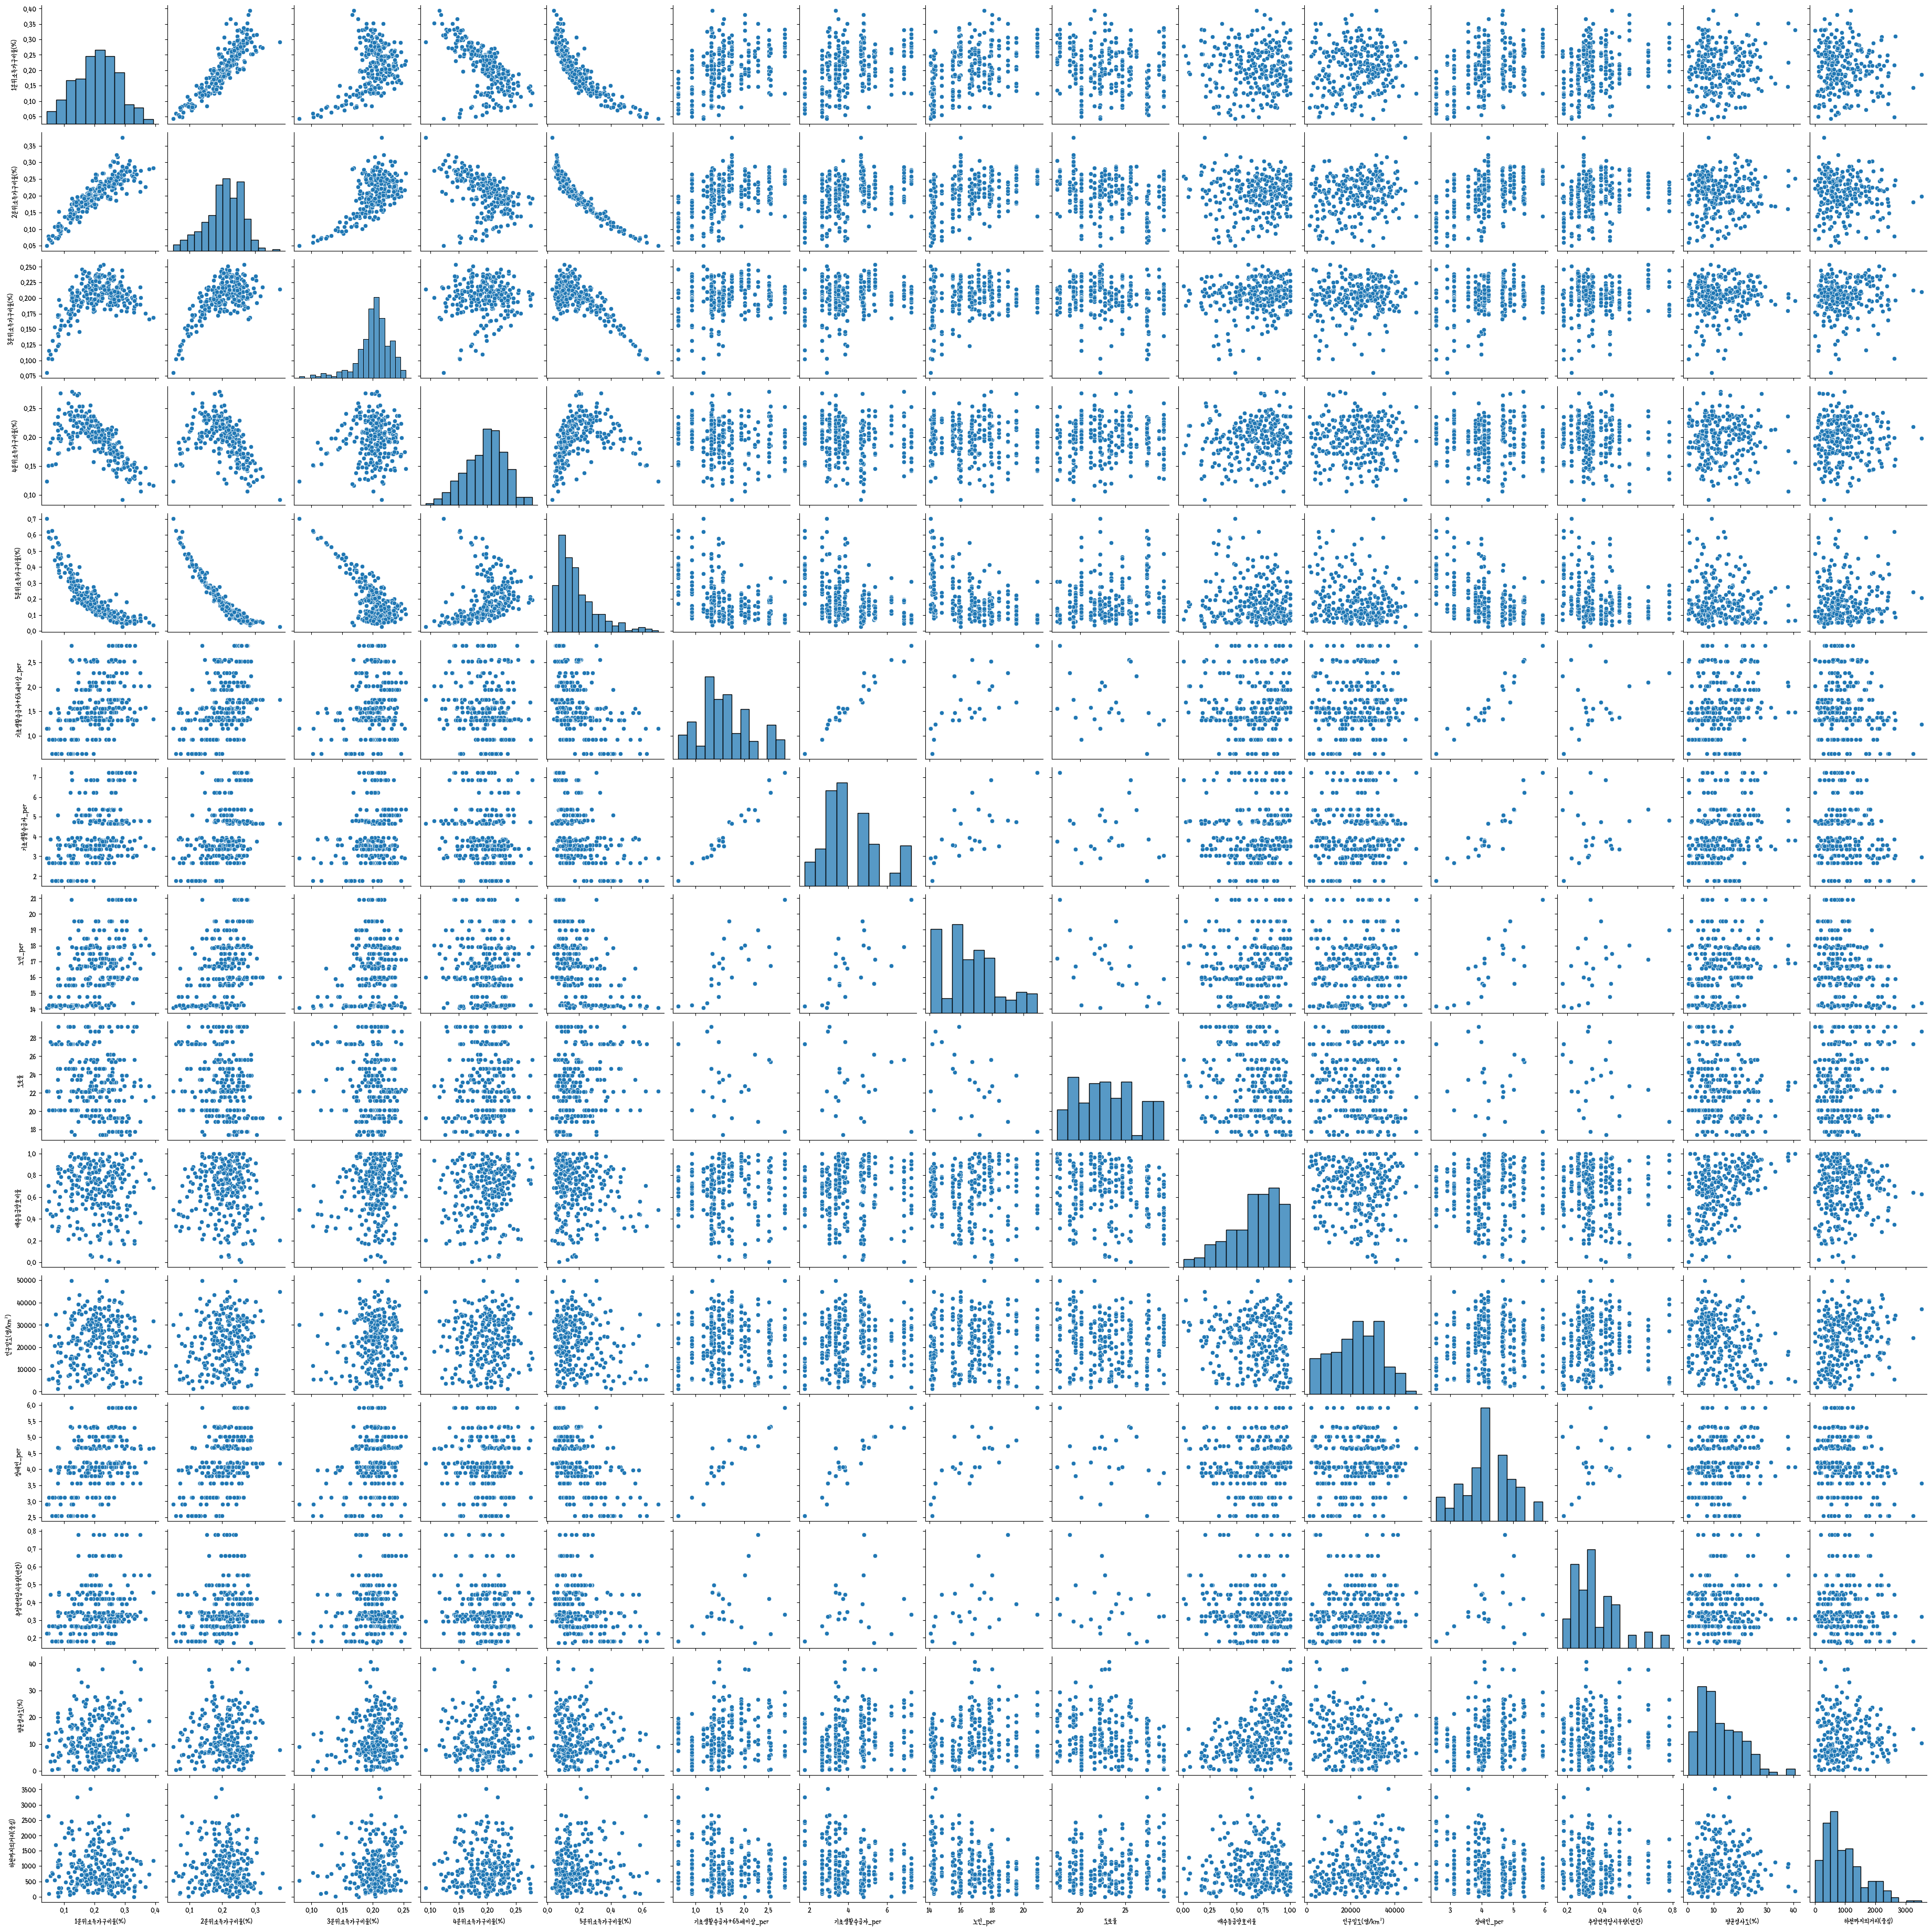

In [89]:
plt.figure()
sb.pairplot(침수발생[numeric])
plt.show()
plt.close()

상관계수

In [90]:
침수발생[numeric].corr(method="pearson").abs().style.background_gradient(cmap="PuBu")

,1분위소득가구비율(%),2분위소득가구비율(%),3분위소득가구비율(%),4분위소득가구비율(%),5분위소득가구비율(%),기초생활수급자+65세이상_per,기초생활수급자_per,노인_per,도로율,배수등급양호비율,인구밀도(명/km²),장애인_per,추정면적당시우량(연간),평균경사도(%),하천까지의거리(중심)
1분위소득가구비율(%),1.000000,0.879304,0.426190,0.632771,0.873050,0.414627,0.374443,0.426861,0.165908,0.016720,0.087502,0.424729,0.259054,0.084171,0.078729
2분위소득가구비율(%),0.879304,1.000000,0.630268,0.460273,0.948357,0.367999,0.372660,0.363054,0.222971,0.028753,0.204684,0.413713,0.173951,0.063421,0.068133
3분위소득가구비율(%),0.426190,0.630268,1.000000,0.080235,0.755714,0.210591,0.221820,0.188670,0.145776,0.147351,0.147714,0.242208,0.106185,0.093100,0.071897
4분위소득가구비율(%),0.632771,0.460273,0.080235,1.000000,0.272665,0.089356,0.044898,0.057761,0.059683,0.133557,0.039341,0.001892,0.108619,0.011432,0.008486
5분위소득가구비율(%),0.873050,0.948357,0.755714,0.272665,1.000000,0.417409,0.411179,0.425920,0.207291,0.090113,0.181862,0.474620,0.216438,0.098596,0.061282
기초생활수급자+65세이상_per,0.414627,0.367999,0.210591,0.089356,0.417409,1.000000,0.975252,0.767406,0.236468,0.025632,0.012020,0.925299,0.358776,0.199897,0.159394
기초생활수급자_per,0.374443,0.372660,0.221820,0.044898,0.411179,0.975252,1.000000,0.733338,0.227626,0.042526,0.045626,0.918191,0.277083,0.213596,0.166366
노인_per,0.426861,0.363054,0.188670,0.057761,0.425920,0.767406,0.733338,1.000000,0.369738,0.045847,0.031051,0.839105,0.420647,0.197031,0.276060
도로율,0.165908,0.222971,0.145776,0.059683,0.207291,0.236468,0.227626,0.369738,1.000000,0.171251,0.065156,0.197900,0.247404,0.206567,0.159673
배수등급양호비율,0.016720,0.028753,0.147351,0.133557,0.090113,0.025632,0.042526,0.045847,0.171251,1.000000,0.099622,0.041730,0.100800,0.438769,0.030097


이상치

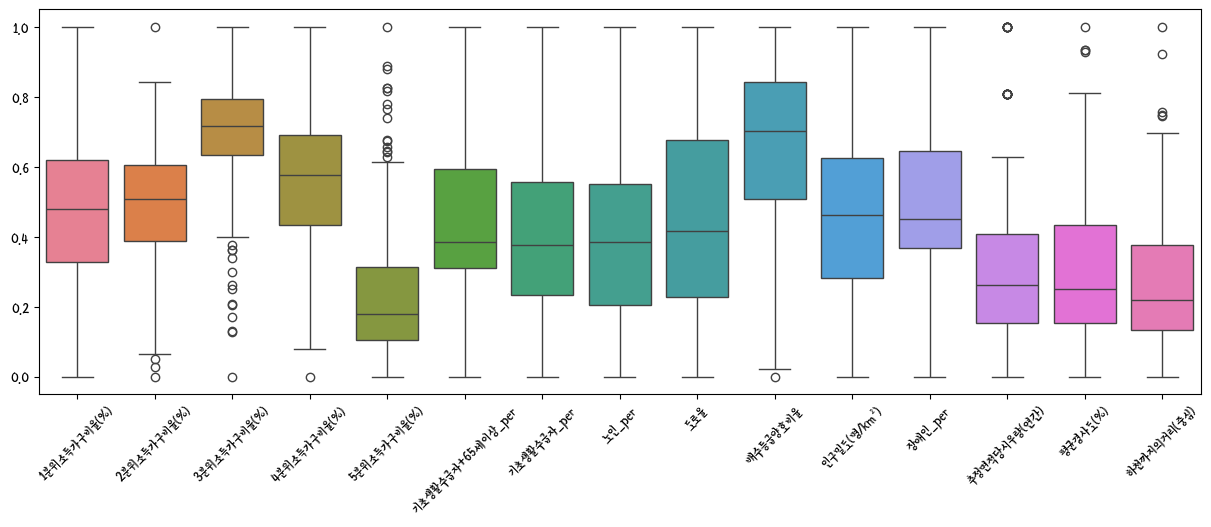

In [91]:
plt.figure(figsize=(15,5))
sb.boxplot(pre_df[numeric])
plt.xticks(rotation=45)
plt.show()
plt.close()

* 소득분위가구수 비율은 합이 1이므로 소득분위 가구수 하나 제거가 필요          

### VIF

In [92]:
vif_result=[]
vif_columns=numeric[:]
for col in vif_columns:
    other_cols=[x for x in vif_columns if x!=col]
    temp=sm.OLS(endog=pre_df[col],exog=sm.add_constant(pre_df[other_cols])).fit()
    vif_result.append({'feature':col,"vif":1/(1-temp.rsquared)})

In [93]:
pd.DataFrame(vif_result).sort_values("vif",ascending=False)

,feature,vif
4,5분위소득가구비율(%),185643.696509
0,1분위소득가구비율(%),59651.215510
1,2분위소득가구비율(%),35604.640313
3,4분위소득가구비율(%),13548.491382
2,3분위소득가구비율(%),8705.594179
5,기초생활수급자+65세이상_per,33.715165
6,기초생활수급자_per,31.286198
11,장애인_per,15.630446
7,노인_per,4.746233
12,추정면적당시우량(연간),1.577615


---

In [94]:
vif_columns.remove("5분위소득가구비율(%)")

In [95]:
vif_result=[]
for col in vif_columns:
    other_cols=[x for x in vif_columns if x!=col]
    temp=sm.OLS(endog=pre_df[col],exog=sm.add_constant(pre_df[other_cols])).fit()
    vif_result.append({'feature':col,"vif":1/(1-temp.rsquared)})
pd.DataFrame(vif_result).sort_values("vif",ascending=False)

,feature,vif
4,기초생활수급자+65세이상_per,33.528859
5,기초생활수급자_per,31.021328
10,장애인_per,15.622227
1,2분위소득가구비율(%),9.490334
0,1분위소득가구비율(%),8.622445
6,노인_per,4.732564
3,4분위소득가구비율(%),3.043880
2,3분위소득가구비율(%),2.695863
11,추정면적당시우량(연간),1.577156
7,도로율,1.536028


---

In [96]:
vif_columns.remove("기초생활수급자+65세이상_per")

In [97]:
vif_result=[]
for col in vif_columns:
    other_cols=[x for x in vif_columns if x!=col]
    temp=sm.OLS(endog=pre_df[col],exog=sm.add_constant(pre_df[other_cols])).fit()
    vif_result.append({'feature':col,"vif":1/(1-temp.rsquared)})
pd.DataFrame(vif_result).sort_values("vif",ascending=False)

,feature,vif
9,장애인_per,14.967672
1,2분위소득가구비율(%),8.496924
4,기초생활수급자_per,8.333318
0,1분위소득가구비율(%),7.986150
5,노인_per,4.713133
3,4분위소득가구비율(%),2.997519
2,3분위소득가구비율(%),2.640070
6,도로율,1.524266
11,평균경사도(%),1.499460
10,추정면적당시우량(연간),1.493284


---

In [98]:
test_numeric=vif_columns[:]
test_numeric.remove("장애인_per")
vif_result=[]
for col in test_numeric:
    other_cols=[x for x in test_numeric if x!=col]
    temp=sm.OLS(endog=pre_df[col],exog=sm.add_constant(pre_df[other_cols])).fit()
    vif_result.append({'feature':col,"vif":1/(1-temp.rsquared)})
pd.DataFrame(vif_result).sort_values("vif",ascending=False)

,feature,vif
1,2분위소득가구비율(%),8.101746
0,1분위소득가구비율(%),7.977380
5,노인_per,3.077493
3,4분위소득가구비율(%),2.678111
2,3분위소득가구비율(%),2.546315
4,기초생활수급자_per,2.317697
10,평균경사도(%),1.464042
7,배수등급양호비율,1.349606
6,도로율,1.335042
9,추정면적당시우량(연간),1.332378


In [99]:
test_cols=test_numeric+category
test_cols

['1분위소득가구비율(%)',
 '2분위소득가구비율(%)',
 '3분위소득가구비율(%)',
 '4분위소득가구비율(%)',
 '기초생활수급자_per',
 '노인_per',
 '도로율',
 '배수등급양호비율',
 '인구밀도(명/km²)',
 '추정면적당시우량(연간)',
 '평균경사도(%)',
 '하천까지의거리(중심)',
 '수문',
 '제방']

In [100]:
model=sm.OLS(exog=sm.add_constant(pre_df[test_cols]),endog=pre_df[target_cols]).fit()

In [101]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   침수횟수   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     4.419
Date:                Sun, 29 Oct 2023   Prob (F-statistic):           4.64e-07
Time:                        16:40:48   Log-Likelihood:                -1508.6
No. Observations:                 265   AIC:                             3047.
Df Residuals:                     250   BIC:                             3101.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           27.7757     39.493      0.703      0.483     -50.005     105.557
1분위소득가구비율(%)    43.4796     64.081      0.679      0.498     -82.729     169.688
2분위소득가구비율(%)   119.3126     77.020      1.549      0.123     -32.379     271.004
3분위소득가구비율(%)   -59.0134     46.071     -1.281      0.201    -149.749      31.723
4분위소득가구비율(%)    10.4080     40.750      0.255      0.799     -69.850      90.666
기초생활수급자_per    -92.6427     27.581     -3.359      0.001    -146.964     -38.321
노인_per          12.4372     30.440      0.409      0.683     -47.514      72.388
도로율             63.1944     18.585      3.400      0.001      26.591      99.798
배수등급양호비율       -53.0606     22.725     -2.335      0.020     -97.817      -8.304
인구밀도(명/km²)     37.2165     24.797      1.501      0.135     -11.622      86.055
추정면적당시우량(연간)    -0.1278     24.373     -0.005      0.996     -48.131      47.875
평균경사도(%)        33.5751     28.242      1.189      0.236     -22.048      89.198
하천까지의거리(중심)    -36.8147     31.257     -1.178      0.240     -98.375      24.745
수문              -6.1179     11.455     -0.534      0.594     -28.678      16.442
제방             -16.5555     13.159     -1.258      0.210     -42.472       9.361
==============================================================================
Omnibus:                      314.376   Durbin-Watson:                   1.222
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            20294.228
Skew:                           5.046   Prob(JB):                         0.00
Kurtosis:                      44.667   Cond. No.                         44.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### step 1. PCA

In [102]:
import scipy as sp

In [103]:
corr_matrix=pre_df[numeric].corr(method='pearson')
eigen_value,eigen_vector=sp.linalg.eig(corr_matrix)
eigen_value=eigen_value/sum(eigen_value)
PCA_result=pd.DataFrame(eigen_value,columns=["eigen_value"])
PCA_result['주성분']=[f'제 {i+1}성분' for i in range(len(numeric))]
PCA_result.sort_values(by="eigen_value",ascending=False,inplace=True)

In [104]:
PCA_result[["주성분","eigen_value"]]

,주성분,eigen_value
0,제 1성분,3.557583e-01+0.000000e+ 00j
1,제 2성분,1.504800e-01+0.000000e+ 00j
2,제 3성분,1.068859e-01+0.000000e+ 00j
3,제 4성분,8.955826e-02+0.000000e+ 00j
5,제 6성분,6.914058e-02+0.000000e+ 00j
4,제 5성분,6.697157e-02+0.000000e+ 00j
6,제 7성분,5.121520e-02+0.000000e+ 00j
7,제 8성분,3.848335e-02+0.000000e+ 00j
8,제 9성분,3.088590e-02+0.000000e+ 00j
9,제 10성분,1.874826e-02+0.000000e+ 00j


엘보우 method :주성분마다의 eigen_value값들 시각화

c:\Users\SAMSUNG\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\SAMSUNG\AppData\Local\Programs\Python\Python312\Lib\site-packages\pandas\core\dtypes\astype.py:134: ComplexWarning: Casting complex values to real discards the imaginary part
  return arr.astype(dtype, copy=True)


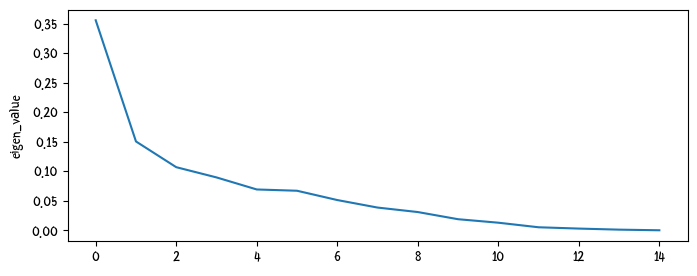

In [105]:
plt.figure(figsize=(8,3))
sb.lineplot(PCA_result,x=range(len(PCA_result)),y=PCA_result["eigen_value"])
plt.show()
plt.close()

위의 결과로 주성분 2개

In [106]:
PCA_df=pre_df[numeric]@eigen_vector[:2].T
PCA_df.rename(columns=dict(zip([0,1],[f"제{i+1}성분" for i in range(2)])),inplace=True)

요인적재값

In [107]:
factor_analysis=pd.DataFrame(sp.linalg.lstsq(a=pre_df[numeric],b=PCA_df)[0])
factor_analysis.index=numeric
factor_analysis.rename(columns=dict(zip([0,1],[f"제{i+1}성분" for i in range(2)])),inplace=True)

In [108]:
factor_analysis.abs().sort_values(["제1성분"],ascending=False).style.background_gradient("PuBu")

,제1성분,제2성분
장애인_per,0.593307,0.643497
추정면적당시우량(연간),0.443577,0.342672
2분위소득가구비율(%),0.338397,0.382548
1분위소득가구비율(%),0.335412,0.336350
인구밀도(명/km²),0.246374,0.257733
4분위소득가구비율(%),0.237473,0.033909
배수등급양호비율,0.189732,0.008885
평균경사도(%),0.186568,0.321198
하천까지의거리(중심),0.125918,0.148504
노인_per,0.112271,0.023650


#### Polynomial

In [109]:
y_data = target.copy()
y =y_data['ADM_NM']
frequency = pd.DataFrame({"FREQUENCY":y.value_counts()})
frequency.reset_index(inplace=True)

In [110]:
frequency[frequency['ADM_NM'] == "가락1동"]
frequency

,ADM_NM,FREQUENCY
0,대림2동,880
1,대림1동,527
2,신길6동,397
3,신길5동,362
4,사당1동,270
...,...,...
272,종로5·6가동,1
273,이화동,1
274,삼각산동,1
275,목1동,1


In [111]:
data = pd.merge(통합,frequency,on="ADM_NM")
data.drop_duplicates('ADM_NM',inplace=True)

In [112]:
x = data.drop(["GU_NAME","ADM_NM","침수횟수","FREQUENCY"],axis=1)
y = data['침수횟수']
x.shape, y.shape

((265, 17), (265,))

In [113]:
x

,배수등급양호비율,제방,수문,평균경사도(%),하천까지의거리(중심),인구밀도(명/km²),1분위소득가구비율(%),2분위소득가구비율(%),3분위소득가구비율(%),4분위소득가구비율(%),5분위소득가구비율(%),도로율,노인_per,장애인_per,기초생활수급자_per,기초생활수급자+65세이상_per,추정면적당시우량(연간)
0,0.654167,1.0,0.0,3.812500,542.994437,20605.223880,6.976744,10.697674,15.348837,22.325581,44.186047,20.14,14.259492,3.117333,2.653057,0.920666,0.265643
2,0.842105,0.0,0.0,7.125000,1074.589206,32888.541670,12.245310,14.877950,18.045189,24.329231,30.512407,20.14,14.259492,3.117333,2.653057,0.920666,0.265643
3,0.680000,0.0,0.0,10.785714,2056.158356,22821.238940,12.462591,17.507482,20.500214,23.535699,25.983326,20.14,14.259492,3.117333,2.653057,0.920666,0.265643
4,0.688073,0.0,0.0,9.666667,1184.743571,31655.000000,39.355304,28.337744,16.911234,11.594900,3.800818,21.55,17.483236,4.669164,3.372114,1.338061,0.454219
5,0.610245,1.0,0.0,8.772727,468.909180,10567.857140,22.982635,26.710930,25.362615,14.484168,10.459653,22.37,17.127026,5.017209,5.388524,2.088480,0.662113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520,0.927681,1.0,0.0,16.866667,753.698775,14307.766990,22.693467,21.949749,19.989950,21.246231,14.120603,17.46,17.205958,4.073199,3.748701,1.558330,0.420717
522,0.206349,1.0,0.0,4.000000,561.032696,41493.939390,21.637306,21.409326,22.569948,19.274611,15.129534,18.86,18.991788,4.726233,4.810223,2.285956,0.779388
524,0.935484,1.0,0.0,38.000000,1080.986380,17997.368420,35.221546,27.576021,20.086881,10.634231,6.463944,22.74,18.002722,4.645774,4.781744,2.017811,0.552905
526,0.826733,1.0,0.0,19.875000,745.755148,6141.666667,27.197266,18.652344,17.236328,13.769531,23.144531,18.86,18.991788,4.726233,4.810223,2.285956,0.779388


In [114]:
minmax=skpre.MinMaxScaler()
x_minmax=minmax.fit_transform(x)
x_minmax = pd.DataFrame(x_minmax,columns = x.columns)

In [115]:
x_scale = pd.concat([data['GU_NAME'],data['ADM_NM'],x_minmax],axis=1)

In [116]:
ols = sm.OLS(y,x_minmax).fit()
ols.summary()

ValueError: The indices for endog and exog are not aligned